In [3]:
# Build one labeled dataset from every month, show a verification sample,
# detect and drop conflicts, run hygiene checks, and export review files.
# Outputs (Parquet, kept for speed and downstream use):
#   data/interim/events_all.parquet
#   data/interim/labeled_all.parquet
#   data/interim/labeled_all_clean.parquet
#   data/interim/coverage_by_month.parquet

from pathlib import Path
import time
import pandas as pd
import polars as pl
from src.cleaning_utils import normalize_text

# toggle this if you really need the single Excel file
WRITE_EXCEL = False

t0 = time.perf_counter()

# locate folders
try:
    DATA, RAW, INTERIM  # type: ignore
except NameError:
    candidates = [Path.cwd(), *Path.cwd().parents]
    project_root = next((p for p in candidates if (p / "src").exists() and (p / "data").exists()), None)
    if project_root is None:
        raise RuntimeError(f"Could not find project root from {Path.cwd()}")
    DATA = project_root / "data"
    RAW = DATA / "raw"
    INTERIM = DATA / "interim"
    INTERIM.mkdir(parents=True, exist_ok=True)

pd.set_option("display.max_colwidth", None)
pd.set_option("display.max_rows", 200)
pd.set_option("display.width", 0)

# read labels; keep original and cleaned
t_labels = time.perf_counter()
LABELS_XLSX = next((DATA / "labels").glob("*.xls*"))
print("labels file:", LABELS_XLSX)

labels_df = pd.read_excel(LABELS_XLSX, engine="openpyxl")
cols = {c.lower().strip(): c for c in labels_df.columns}
assert "product_name" in cols, "expected 'product_name' column in labels"
if "relevant_code" in cols:
    labels_df["label"] = (labels_df[cols["relevant_code"]] == 1).astype("int8")
elif "label" not in cols:
    raise AssertionError("expected 'relevant_code' or 'label' column in labels")
labels_df = labels_df.rename(columns={cols["product_name"]: "product_name_original"})
labels_df["product_text"] = labels_df["product_name_original"].astype(str).map(normalize_text)
labels_pl = pl.from_pandas(labels_df[["product_text", "label", "product_name_original"]]).unique()

# detect conflicting cleaned names in label sheet
conflicts = (
    labels_pl.group_by("product_text")
             .agg(pl.col("label").n_unique().alias("n_labels"))
             .filter(pl.col("n_labels") > 1)
)
print("conflicting cleaned names in label sheet:", conflicts.height)
print(f"time: labels read and normalized in {time.perf_counter() - t_labels:.1f}s")

# parse month tags like export_shopper=AUG-24 into sortable yyyymm
MONTH_MAP = dict(JAN=1,FEB=2,MAR=3,APR=4,MAY=5,JUN=6,JUL=7,AUG=8,SEP=9,OCT=10,NOV=11,DEC=12)
def parse_month_tag(folder_name: str):
    tag = folder_name.split("export_shopper=")[-1]
    mmm, yy = tag.split("-")
    year = 2000 + int(yy)
    month = MONTH_MAP[mmm.upper()]
    yyyymm = year * 100 + month
    return tag, yyyymm

# gather month folders
month_dirs = [p for p in RAW.iterdir() if p.is_dir() and p.name.startswith("export_shopper=")]
month_dirs = sorted(month_dirs, key=lambda p: parse_month_tag(p.name)[1])
print("months found:", [parse_month_tag(p.name)[0] for p in month_dirs])

# read, clean, dedupe per month
t_read = time.perf_counter()
per_month = []
for mdir in month_dirs:
    tag, yyyymm = parse_month_tag(mdir.name)
    files = sorted(mdir.rglob("*.json"))
    if not files:
        print("no files in", mdir)
        continue
    dfs = []
    for fp in files:
        try:
            df = (
                pl.read_ndjson(str(fp), infer_schema_length=1000)
                  .select(pl.col("remove_amazon").cast(pl.Utf8).alias("raw_text"))
            )
            dfs.append(df)
        except Exception as e:
            print("skip", fp.name, "->", e)
    ev = (
        pl.concat(dfs, how="vertical")
          .with_columns(pl.col("raw_text").map_elements(normalize_text).alias("product_text"))
          .select("product_text")
          .with_columns(pl.col("product_text").str.len_chars().alias("txt_len"))
          .filter(pl.col("txt_len") > 0)
          .drop("txt_len")
          .unique()
          .with_columns(
              pl.lit(tag).alias("month_tag"),
              pl.lit(yyyymm).alias("yyyymm")
          )
    )
    print(tag, "unique names:", ev.height)
    per_month.append(ev)
print(f"time: read/clean/dedupe events in {time.perf_counter() - t_read:.1f}s")

events_all = pl.concat(per_month, how="vertical") if per_month else pl.DataFrame({"product_text": [], "month_tag": [], "yyyymm": []})
print("all months unique names (sum over months):", events_all.height)

# join to labels and compute coverage
t_join = time.perf_counter()
joined = events_all.join(labels_pl.select("product_text","label"), on="product_text", how="left")
cov_events = (joined.group_by("month_tag")
                    .agg(pl.len().alias("unique_names"),
                         pl.col("label").is_not_null().sum().alias("matched_labeled"))
                    .with_columns((pl.col("matched_labeled")/pl.col("unique_names")).alias("coverage"))
                    .sort("month_tag"))
print("\ncoverage by month (unique_names, matched_labeled, coverage):")
print(cov_events)
print(f"time: join + coverage in {time.perf_counter() - t_join:.1f}s")

# labeled rows
labeled_all = joined.filter(pl.col("label").is_not_null()).select("product_text","label","month_tag","yyyymm")
print("\nlabeled rows total (before cleaning conflicts):", labeled_all.height)

# verification sample (100 rows) with original labeled text
verify = labeled_all.join(labels_pl, on=["product_text","label"], how="left")
verify_pd = verify.select("month_tag","product_text","product_name_original","label").to_pandas()

# drop conflicts and literal "nan"
bad_names = set(conflicts.select("product_text").to_series().to_list())
labeled_all_clean = (
    labeled_all
      .filter(~pl.col("product_text").is_in(list(bad_names)))
      .filter(pl.col("product_text") != "nan")
)
print("\nlabeled rows after dropping conflicts and 'nan':", labeled_all_clean.height)

# hygiene checks
empties = labeled_all_clean.filter(pl.col("product_text").str.len_chars()==0).height
print("empty product_text rows after cleaning:", empties)

multi_month = (labeled_all_clean
               .group_by("product_text")
               .agg(pl.col("month_tag").n_unique().alias("months_seen"))
               .filter(pl.col("months_seen") > 1))
print("names appearing in multiple months:", multi_month.height)

by_month = (labeled_all_clean
            .group_by(["month_tag","label"])
            .len()
            .sort(["month_tag","label"]))
print("\nclass balance by month (label counts):")
print(by_month)

beauty_terms = ["shampoo","conditioner","lip","gloss","mascara","foundation","palette","eyeliner","lipstick","blush","nail","polish","serum","skincare"]
bt = (labeled_all_clean
      .filter(pl.col("label")==1)
      .with_columns(pl.col("product_text").str.split(" ").alias("toks"))
      .explode("toks")
      .filter(pl.col("toks").is_in(beauty_terms))
      .group_by("toks").len()
      .sort("len", descending=True))
print("\nbeauty tokens found in label=1 (may indicate label noise):")
print(bt)

# write core Parquet artifacts
t_write = time.perf_counter()
events_all.write_parquet(INTERIM / "events_all.parquet")
labeled_all.write_parquet(INTERIM / "labeled_all.parquet")
labeled_all_clean.write_parquet(INTERIM / "labeled_all_clean.parquet")
cov_events.write_parquet(INTERIM / "coverage_by_month.parquet")
print("\nwrote:", INTERIM / "events_all.parquet")
print("wrote:", INTERIM / "labeled_all.parquet")
print("wrote:", INTERIM / "labeled_all_clean.parquet")
print("wrote:", INTERIM / "coverage_by_month.parquet")

# write review CSVs (fast)
verify_csv = INTERIM / "verify_sample_100.csv"
verify_pd.sample(n=min(100, len(verify_pd)), random_state=42).to_csv(verify_csv, index=False)
print("wrote:", verify_csv)

if conflicts.height:
    conflict_details = conflicts.select("product_text").join(labels_pl, on="product_text", how="left").to_pandas()
    conflicts_csv = INTERIM / "conflicts.csv"
    conflict_details.to_csv(conflicts_csv, index=False)
    print("wrote:", conflicts_csv)

labels file: /Users/ramana/Documents/Homework/1st class ML opt/Project 1/Product-Classifcation/data/labels/google_fashion_retailer_cleaning_final - FOR MSU.xlsm
conflicting cleaned names in label sheet: 8
time: labels read and normalized in 16.5s
months found: ['MAY-24', 'JUN-24', 'JUL-24', 'AUG-24', 'SEP-24', 'OCT-24', 'NOV-24', 'DEC-24', 'JAN-25', 'FEB-25']
MAY-24 unique names: 76042
JUN-24 unique names: 92768
JUL-24 unique names: 126716
AUG-24 unique names: 124166
SEP-24 unique names: 212043
OCT-24 unique names: 466610
NOV-24 unique names: 493980
DEC-24 unique names: 540725
JAN-25 unique names: 429498
FEB-25 unique names: 78393
time: read/clean/dedupe events in 226.9s
all months unique names (sum over months): 2640941

coverage by month (unique_names, matched_labeled, coverage):
shape: (10, 4)
┌───────────┬──────────────┬─────────────────┬──────────┐
│ month_tag ┆ unique_names ┆ matched_labeled ┆ coverage │
│ ---       ┆ ---          ┆ ---             ┆ ---      │
│ str       ┆ u32 

In [4]:
# Leakage-safe time holdout with explicit overlap checks and fixed dtypes.

from pathlib import Path
import numpy as np
import pandas as pd
import polars as pl
from sklearn.model_selection import train_test_split

# locate data folders if needed
try:
    DATA, INTERIM  # type: ignore
except NameError:
    candidates = [Path.cwd(), *Path.cwd().parents]
    project_root = next((p for p in candidates if (p / "src").exists() and (p / "data").exists()), None)
    if project_root is None:
        raise RuntimeError(f"Could not find project root from {Path.cwd()}")
    DATA = project_root / "data"
    INTERIM = DATA / "interim"

# 1) load cleaned labels across all months
lab = pl.read_parquet(INTERIM / "labeled_all_clean.parquet")

# 2) pick global latest month
latest_yyyymm = lab.select(pl.col("yyyymm").max()).item()
latest_tag = lab.filter(pl.col("yyyymm")==latest_yyyymm).select("month_tag").unique().item()
print("latest month (test target):", latest_tag)

# 3) groups whose latest occurrence is the latest month
grp_max = (lab.group_by("product_text")
             .agg(pl.col("yyyymm").max().alias("max_yyyymm")))
test_groups = grp_max.filter(pl.col("max_yyyymm")==latest_yyyymm).select("product_text")

# 4) test = only latest-month rows for those groups
test_df = (lab.join(test_groups, on="product_text", how="inner")
              .filter(pl.col("yyyymm")==latest_yyyymm))

# 5) remove those groups entirely from train/val pool (prevents leakage)
trainval_df = lab.join(test_groups, on="product_text", how="anti")

earlier_removed = (lab.join(test_groups, on="product_text", how="inner")
                     .filter(pl.col("yyyymm") < latest_yyyymm).height)
print("rows removed from earlier months to avoid group leakage:", earlier_removed)

# 6) arrays for stratified, group-aware train/val split
pdf_tv = trainval_df.select("product_text","label").to_pandas()
X_tv = pdf_tv["product_text"].values
y_tv = pdf_tv["label"].astype(int).values
groups_tv = pdf_tv["product_text"].values  # group = cleaned name

# try StratifiedGroupKFold; fallback to group-level stratify
try:
    from sklearn.model_selection import StratifiedGroupKFold
    sgkf = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=42)
    tr_idx, val_idx = next(sgkf.split(X_tv, y_tv, groups=groups_tv))
    X_tr, y_tr = X_tv[tr_idx], y_tv[tr_idx]
    X_val, y_val = X_tv[val_idx], y_tv[val_idx]
except Exception:
    gdf = (trainval_df.select(["product_text","label"])
            .group_by("product_text")
            .agg(pl.col("label").mean().alias("label_mean")))
    gpdf = gdf.to_pandas()
    gpdf["label_bin"] = (gpdf["label_mean"]>=0.5).astype(int)
    gX = gpdf["product_text"].values
    gy = gpdf["label_bin"].values
    gX_tr, gX_val, gy_tr, gy_val = train_test_split(gX, gy, test_size=0.2, stratify=gy, random_state=42)
    mask_tr = np.isin(X_tv, gX_tr)
    mask_val = np.isin(X_tv, gX_val)
    X_tr, y_tr = X_tv[mask_tr], y_tv[mask_tr]
    X_val, y_val = X_tv[mask_val], y_tv[mask_val]

# 7) test arrays
pdf_te = test_df.select("product_text","label").to_pandas()
X_test = pdf_te["product_text"].values
y_test = pdf_te["label"].astype(int).values

# 8) explicit leakage checks
S_tr, S_val, S_te = set(X_tr), set(X_val), set(X_test)
print("\nGroup overlap checks (should all be 0):")
print("train ∩ val:", len(S_tr & S_val))
print("train ∩ test:", len(S_tr & S_te))
print("val   ∩ test:", len(S_val & S_te))

if (S_tr & S_val) or (S_tr & S_te) or (S_val & S_te):
    raise RuntimeError("Leakage detected: some product_text appears in more than one split.")

# 9) summarize sizes and class mix
def summarize(name, X, y):
    import collections
    c = collections.Counter(y)
    n = len(y)
    pct1 = (c.get(1,0)/n*100) if n else 0.0
    print(f"{name}: n={n}  class1={c.get(1,0)} ({pct1:.1f}%)  class0={c.get(0,0)}")

summarize("train", X_tr, y_tr)
summarize("val",   X_val, y_val)
summarize("test",  X_test, y_test)

# 10) save split tables (unified dtypes to avoid SchemaError)
def to_pl_tbl(name, X, y):
    return (pl.DataFrame({"product_text": X, "label": y, "split": [name]*len(X)})
              .with_columns([
                  pl.col("product_text").cast(pl.Utf8),
                  pl.col("label").cast(pl.Int8),     # unify dtype
                  pl.col("split").cast(pl.Utf8),
              ]))

train_tbl = to_pl_tbl("train", X_tr, y_tr)
val_tbl   = to_pl_tbl("val",   X_val, y_val)
test_tbl  = (test_df
             .select("product_text","label","month_tag","yyyymm")
             .with_columns([
                 pl.col("product_text").cast(pl.Utf8),
                 pl.col("label").cast(pl.Int8),     # unify dtype
                 pl.lit("test").alias("split").cast(pl.Utf8),
             ]))

# columns to keep in the combined file
cols = ["product_text","label","split"]
splits = pl.concat([
    train_tbl.select(cols),
    val_tbl.select(cols),
    test_tbl.select(cols),
], how="vertical", rechunk=True)

splits_path = INTERIM / "splits_no_leak.parquet"
splits.write_parquet(splits_path)
print("\nwrote:", splits_path)
print("dtypes:", splits.dtypes)

latest month (test target): FEB-25
rows removed from earlier months to avoid group leakage: 2594

Group overlap checks (should all be 0):
train ∩ val: 0
train ∩ test: 0
val   ∩ test: 0
train: n=27179  class1=22896 (84.2%)  class0=4283
val: n=6851  class1=5829 (85.1%)  class0=1022
test: n=763  class1=669 (87.7%)  class0=94

wrote: /Users/ramana/Documents/Homework/1st class ML opt/Project 1/Product-Classifcation/data/interim/splits_no_leak.parquet
dtypes: [String, Int8, String]


sizes -> train: 27179 val: 6851 test: 763

Validation (default 0.5):
val thr=0.500 acc=0.9702 macroF1=0.9445
[[ 992   30]
 [ 174 5655]]

Test (default 0.5):
test thr=0.500 acc=0.9843 macroF1=0.9655
[[ 94   0]
 [ 12 657]]

Best validation threshold by macro-F1: 0.275  F1=0.9507

Test at tuned threshold:
test tuned thr=0.275 acc=0.9869 macroF1=0.9699
[[ 90   4]
 [  6 663]]

Classification report (test, tuned):
              precision    recall  f1-score   support

           0      0.938     0.957     0.947        94
           1      0.994     0.991     0.993       669

    accuracy                          0.987       763
   macro avg      0.966     0.974     0.970       763
weighted avg      0.987     0.987     0.987       763



<Figure size 400x400 with 0 Axes>

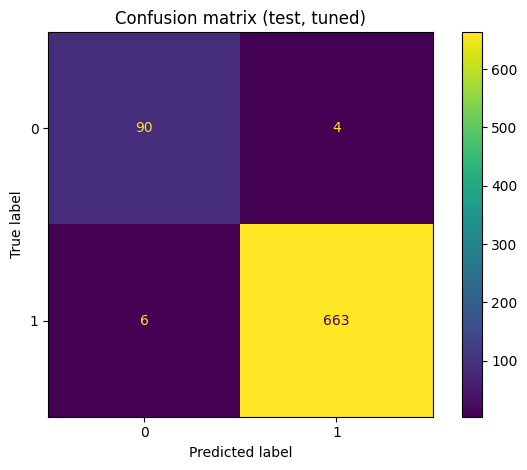

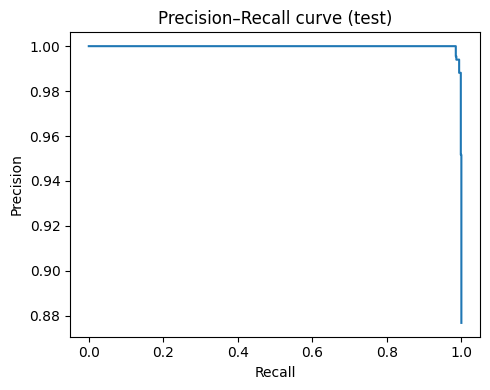

Test PR-AUC (avg precision): 0.9998


In [6]:
# Train/evaluate baseline on leakage-safe splits:
# - TF-IDF fit on train only
# - Logistic Regression (class_weight="balanced")
# - Threshold tuned on validation using macro-F1
# - Final metrics, confusion matrix, PR curve on test

from pathlib import Path
import numpy as np
import pandas as pd
import polars as pl
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, f1_score, classification_report,
                             confusion_matrix, ConfusionMatrixDisplay,
                             precision_recall_curve, average_precision_score)

# load the split we saved
splits_path = INTERIM / "splits_no_leak.parquet"
splits = pl.read_parquet(splits_path)

# recover X/y by split
def xy(df_pl):
    pdf = df_pl.to_pandas()
    return pdf["product_text"].astype(str).values, pdf["label"].astype(int).values

X_tr, y_tr = xy(splits.filter(pl.col("split")=="train").select("product_text","label"))
X_val, y_val = xy(splits.filter(pl.col("split")=="val").select("product_text","label"))
X_te,  y_te  = xy(splits.filter(pl.col("split")=="test").select("product_text","label"))

print("sizes -> train:", len(X_tr), "val:", len(X_val), "test:", len(X_te))

# vectorize text (fit ONLY on train to avoid leakage)
tfidf = TfidfVectorizer(ngram_range=(1,2), min_df=2)
Xtr = tfidf.fit_transform(X_tr)
Xv  = tfidf.transform(X_val)
Xt  = tfidf.transform(X_te)

# model
clf = LogisticRegression(max_iter=2000, class_weight="balanced", n_jobs=None)
clf.fit(Xtr, y_tr)

# scores
val_scores = clf.predict_proba(Xv)[:,1]
te_scores  = clf.predict_proba(Xt)[:,1]

# default 0.5
def report_at(thr, y_true, scores, title):
    y_pred = (scores >= thr).astype(int)
    cm = confusion_matrix(y_true, y_pred)
    acc = accuracy_score(y_true, y_pred)
    mf1 = f1_score(y_true, y_pred, average="macro")
    print(f"{title} thr={thr:.3f} acc={acc:.4f} macroF1={mf1:.4f}")
    print(cm)
    return acc, mf1

print("\nValidation (default 0.5):")
_ = report_at(0.5, y_val, val_scores, "val")

print("\nTest (default 0.5):")
_ = report_at(0.5, y_te, te_scores, "test")

# tune threshold on validation for macro-F1
grid = np.linspace(0.10, 0.90, 33)
best_thr, best_f1 = 0.5, -1
for t in grid:
    f1 = f1_score(y_val, (val_scores >= t).astype(int), average="macro")
    if f1 > best_f1:
        best_thr, best_f1 = t, f1

print(f"\nBest validation threshold by macro-F1: {best_thr:.3f}  F1={best_f1:.4f}")

print("\nTest at tuned threshold:")
acc_t, f1_t = report_at(best_thr, y_te, te_scores, "test tuned")

# detailed report on test at tuned threshold
y_pred_tuned = (te_scores >= best_thr).astype(int)
print("\nClassification report (test, tuned):")
print(classification_report(y_te, y_pred_tuned, digits=3))

# confusion matrix plot (test, tuned)
disp = ConfusionMatrixDisplay(confusion_matrix(y_te, y_pred_tuned), display_labels=[0,1])
plt.figure(figsize=(4,4))
disp.plot(values_format="d")
plt.title("Confusion matrix (test, tuned)")
plt.tight_layout()
plt.show()

# precision-recall curve (test)
precision, recall, thr = precision_recall_curve(y_te, te_scores)
plt.figure(figsize=(5,4))
plt.plot(recall, precision)
plt.title("Precision–Recall curve (test)")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.tight_layout()
plt.show()

# PR-AUC on test
print("Test PR-AUC (avg precision):", round(average_precision_score(y_te, te_scores), 4))

In [7]:
# Create a 100-row human-review file from UNLABELED rows across ALL months.
# Random sample (not filtered by confidence).
# Adds blank columns for you to mark reviewer_label (0/1) and notes.

from pathlib import Path
import numpy as np
import pandas as pd
import polars as pl

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score

# Locate data folders
try:
    DATA, INTERIM  # type: ignore
except NameError:
    candidates = [Path.cwd(), *Path.cwd().parents]
    project_root = next((p for p in candidates if (p / "src").exists() and (p / "data").exists()), None)
    if project_root is None:
        raise RuntimeError(f"Could not find project root from {Path.cwd()}")
    DATA = project_root / "data"
    INTERIM = DATA / "interim"
    INTERIM.mkdir(parents=True, exist_ok=True)

# Inputs produced earlier
splits = pl.read_parquet(INTERIM / "splits_no_leak.parquet")          # product_text, label, split
events_all = pl.read_parquet(INTERIM / "events_all.parquet")          # product_text, month_tag, yyyymm
labeled_all = pl.read_parquet(INTERIM / "labeled_all_clean.parquet")  # product_text, label, month_tag, yyyymm

# Build UNLABELED pool = all events minus anything present in the labeled table (match on cleaned product_text)
unlabeled_all = events_all.join(
    labeled_all.select("product_text").unique(),
    on="product_text", how="anti"
).unique()

if unlabeled_all.is_empty():
    raise RuntimeError("No unlabeled rows found. Check that events_all and labeled_all_clean exist and are non-empty.")

# Random sample across all months (not by confidence)
N = 100
sample_ul = unlabeled_all.sample(n=min(N, unlabeled_all.height), seed=42)

# Prepare TRAIN/VAL arrays (for scoring only; this does NOT use unlabeled data to train)
def xy(df_pl):
    pdf = df_pl.to_pandas()
    return pdf["product_text"].astype(str).values, pdf["label"].astype(int).values

X_tr, y_tr = xy(splits.filter(pl.col("split")=="train").select("product_text","label"))
X_val, y_val = xy(splits.filter(pl.col("split")=="val").select("product_text","label"))

# TF-IDF on TRAIN ONLY (prevents leakage)
tfidf = TfidfVectorizer(ngram_range=(1,2), min_df=2)
Xtr = tfidf.fit_transform(X_tr)
Xv  = tfidf.transform(X_val)

# Simple linear model
clf = LogisticRegression(max_iter=2000, class_weight="balanced")
clf.fit(Xtr, y_tr)

# Tune threshold on validation for macro-F1 (balances both classes)
val_scores = clf.predict_proba(Xv)[:, 1]
grid = np.linspace(0.10, 0.90, 33)
best_thr, best_f1 = 0.5, -1
for t in grid:
    f1 = f1_score(y_val, (val_scores >= t).astype(int), average="macro")
    if f1 > best_f1:
        best_thr, best_f1 = t, f1

# Score the random unlabeled sample (for your sorting/triage)
pdf_ul = sample_ul.select("month_tag","yyyymm","product_text").to_pandas()
X_ul = tfidf.transform(pdf_ul["product_text"].astype(str).values)
pdf_ul["score"] = clf.predict_proba(X_ul)[:, 1]
pdf_ul["pred"]  = (pdf_ul["score"] >= best_thr).astype(int)

# Add blank columns for your manual review
pdf_ul["reviewer_label"] = ""   # fill with 1 (fashion) or 0 (non-fashion)
pdf_ul["notes"] = ""            # any comments

# Save and show a small preview
out_csv = INTERIM / "review_batch_RANDOM_100_all_months.csv"
pdf_ul.to_csv(out_csv, index=False)

pd.set_option("display.max_colwidth", None)
pd.set_option("display.width", 0)
print(f"Saved: {out_csv}")
print(f"Rows: {len(pdf_ul)}  | tuned threshold: {best_thr:.3f} (val macro-F1 {best_f1:.4f})")
print("\nPreview:")
print(pdf_ul.head(12).to_string(index=False))

Saved: /Users/ramana/Documents/Homework/1st class ML opt/Project 1/Product-Classifcation/data/interim/review_batch_RANDOM_100_all_months.csv
Rows: 100  | tuned threshold: 0.275 (val macro-F1 0.9507)

Preview:
month_tag  yyyymm                                                                                                                                                                                   product_text    score  pred reviewer_label notes
   FEB-25  202502                                                                                                                     mainstays nexgen waterproof anti allergen zippered mattress protector full 0.385965     1                     
   NOV-24  202411                                                                                                   everyday savings fashion solid stripe breastfeeding pregnant women s maternity nursing dress 0.941947     1                     
   JUL-24  202407                                       

In [9]:
# Compare manual labels vs model predictions on your reviewed file
# Prints: matches for 1s, matches for 0s, accuracy, and error counts.

from pathlib import Path
import pandas as pd
from sklearn.metrics import accuracy_score, confusion_matrix

# locate project and data/interim
candidates = [Path.cwd(), *Path.cwd().parents]
project_root = next((p for p in candidates if (p / "src").exists() and (p / "data").exists()), None)
if project_root is None:
    raise RuntimeError(f"Could not find project root from {Path.cwd()}")
INTERIM = project_root / "data" / "interim"

# prefer the scored file if it exists; otherwise use the original review file
paths = []
paths += list(INTERIM.glob("review_batch_RANDOM_100_all_months.csv"))
if not paths:
    raise FileNotFoundError("No review CSV found in data/interim/")
p = max(paths, key=lambda x: x.stat().st_mtime)
print("using file:", p)

df = pd.read_csv(p)
df.columns = [c.strip().lower() for c in df.columns]

# choose prediction column automatically
pred_col = "pred_calib" if "pred_calib" in df.columns else ("pred" if "pred" in df.columns else None)
if pred_col is None:
    raise ValueError("No prediction column found. Expected 'pred_calib' or 'pred'.")

if "reviewer_label" not in df.columns:
    raise ValueError("Missing 'reviewer_label' column with your 0/1 manual labels.")

# parse manual labels strictly as 0/1 (0 = non-fashion, 1 = fashion)
def to_int01(x):
    try:
        return int(float(str(x).strip()))
    except Exception:
        return None

df["_manual"] = df["reviewer_label"].map(to_int01)
df["_pred"] = df[pred_col].map(to_int01)

use = df["_manual"].notna() & df["_pred"].notna()
n = int(use.sum())
if n == 0:
    raise ValueError("No usable rows where both manual and prediction are present.")

y_true = df.loc[use, "_manual"].astype(int).values
y_pred = df.loc[use, "_pred"].astype(int).values

acc = accuracy_score(y_true, y_pred)
cm = confusion_matrix(y_true, y_pred, labels=[0,1])  # [[TN, FP],[FN, TP]]
tn, fp, fn, tp = cm.ravel()

# your requested tallies
correct_1_as_1 = int(tp)  # manual=1 and pred=1
correct_0_as_0 = int(tn)  # manual=0 and pred=0

print(f"rows compared: {n}")
print(f"agreement with human labels on {n} rows: accuracy={acc:.3f}")
print(f"correct fashion (manual=1 & pred=1): {correct_1_as_1}")
print(f"correct non-fashion (manual=0 & pred=0): {correct_0_as_0}")
print(f"false positives (manual=0, pred=1): {int(fp)}")
print(f"false negatives (manual=1, pred=0): {int(fn)}")
print(f"used prediction column: {pred_col}")

using file: /Users/ramana/Documents/Homework/1st class ML opt/Project 1/Product-Classifcation/data/interim/review_batch_RANDOM_100_all_months.csv
rows compared: 100
agreement with human labels on 100 rows: accuracy=0.310
correct fashion (manual=1 & pred=1): 7
correct non-fashion (manual=0 & pred=0): 24
false positives (manual=0, pred=1): 62
false negatives (manual=1, pred=0): 7
used prediction column: pred


Results from the above cells are as follows
- On the clean, leakage-safe FEB-25 test, TF-IDF + Logistic Regression was very strong.
- On a random 100-row human review, we saw many non-fashion items flagged as fashion, mostly with mid scores (about 0.4–0.8).
- That pattern points to two things: scores not being well calibrated and the operating threshold favoring recall over precision on this new mix.
- Best practice is to calibrate probabilities and then pick the decision threshold from the validation precision-recall curve to hit a target precision (e.g., 98%), before checking the test month.

project_root: /Users/ramana/Documents/Homework/1st class ML opt/Project 1/Product-Classifcation
looking for review CSV at: /Users/ramana/Documents/Homework/1st class ML opt/Project 1/Product-Classifcation/data/interim/review_batch_RANDOM_100_all_months.csv exists: True
sizes -> train: 27179  val: 6851  test: 763

Chosen threshold for precision>=0.98 on validation: 0.286
At that point: precision=0.981, recall=0.990


/Users/ramana/anaconda3/envs/fashion-bert/lib/python3.11/site-packages/sklearn/calibration.py:330: FutureWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


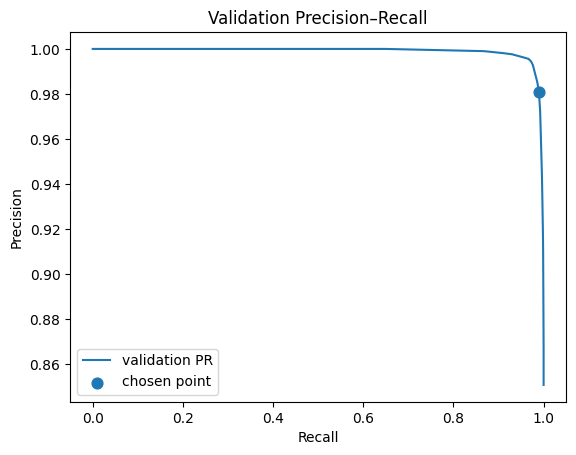


Test metrics at chosen threshold:
accuracy: 0.9869
macro F1: 0.9688
precision (fashion=1): 0.9881
recall (fashion=1): 0.997

classification report (test):
              precision    recall  f1-score   support

           0      0.977     0.915     0.945        94
           1      0.988     0.997     0.993       669

    accuracy                          0.987       763
   macro avg      0.983     0.956     0.969       763
weighted avg      0.987     0.987     0.987       763



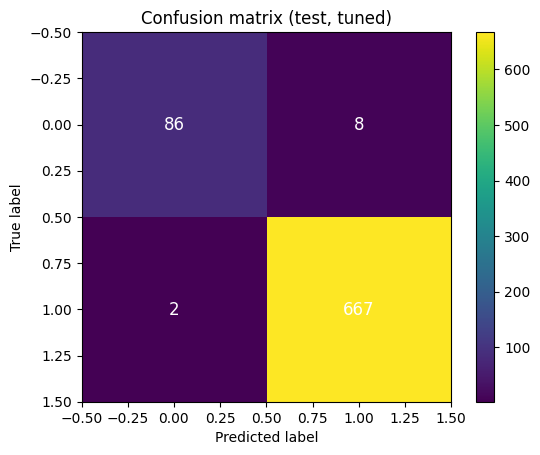


Scored review file written to: /Users/ramana/Documents/Homework/1st class ML opt/Project 1/Product-Classifcation/data/interim/review_batch_RANDOM_100_all_months_scored.csv
agreement with human labels on 100 rows: accuracy=0.300


In [10]:
# Calibrate TF-IDF + LogisticRegression on validation, pick a threshold,
# evaluate on test, and if a human review CSV is present, score it and
# save a new CSV with predicted labels and scores for manual checking.

from pathlib import Path
import sys
import numpy as np
import pandas as pd
import polars as pl
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import (
    precision_recall_curve,
    classification_report,
    confusion_matrix,
    f1_score,
    accuracy_score,
    precision_score,
    recall_score,
)

# --- settings you can change ---
TARGET_PRECISION = 0.98  # raise to 0.98 to reduce false positives further

# --- robust project paths (same logic as earlier cells) ---
candidates = [Path.cwd(), *Path.cwd().parents]
project_root = next((p for p in candidates if (p / "src").exists() and (p / "data").exists()), None)
if project_root is None:
    raise RuntimeError(f"Could not find project root from {Path.cwd()}")

DATA = project_root / "data"
INTERIM = DATA / "interim"
REVIEW_CSV = INTERIM / "review_batch_RANDOM_100_all_months.csv"  # human review file
print("project_root:", project_root)
print("looking for review CSV at:", REVIEW_CSV, "exists:", REVIEW_CSV.exists())

# --- load leakage-safe splits ---
spl = pl.read_parquet(INTERIM / "splits_no_leak.parquet")  # columns: product_text, label, split

def to_xy(df_pl):
    pdf = df_pl.to_pandas()
    return pdf["product_text"].astype(str).values, pdf["label"].astype(int).values

X_tr, y_tr = to_xy(spl.filter(pl.col("split")=="train").select("product_text","label"))
X_val, y_val = to_xy(spl.filter(pl.col("split")=="val").select("product_text","label"))
X_te,  y_te  = to_xy(spl.filter(pl.col("split")=="test").select("product_text","label"))

print(f"sizes -> train: {len(y_tr)}  val: {len(y_val)}  test: {len(y_te)}")

# --- TF-IDF on train only ---
tfidf = TfidfVectorizer(ngram_range=(1,2), min_df=2)
Xtr = tfidf.fit_transform(X_tr)
Xv  = tfidf.transform(X_val)
Xte = tfidf.transform(X_te)

# --- train base classifier ---
base = LogisticRegression(max_iter=2000, class_weight="balanced")
base.fit(Xtr, y_tr)

# --- calibrate on validation only (no contamination) ---
try:
    cal = CalibratedClassifierCV(estimator=base, method="isotonic", cv="prefit")
    cal.fit(Xv, y_val)
except Exception as e:
    print("Isotonic calibration failed, falling back to sigmoid:", e)
    cal = CalibratedClassifierCV(estimator=base, method="sigmoid", cv="prefit")
    cal.fit(Xv, y_val)

# --- pick threshold to reach target precision on validation ---
val_scores = cal.predict_proba(Xv)[:, 1]
prec, rec, thr = precision_recall_curve(y_val, val_scores)
thr_grid = np.r_[thr, 1.0]
mask = prec >= TARGET_PRECISION
if not mask.any():
    chosen_idx = len(prec) - 1
else:
    chosen_idx = int(np.argmax(mask))
chosen_thr = float(thr_grid[chosen_idx])
print(f"\nChosen threshold for precision>={TARGET_PRECISION:.2f} on validation: {chosen_thr:.3f}")
print(f"At that point: precision={prec[chosen_idx]:.3f}, recall={rec[chosen_idx]:.3f}")

# quick PR plot for reference
plt.figure()
plt.plot(rec, prec, label="validation PR")
plt.scatter(rec[chosen_idx], prec[chosen_idx], s=60, label="chosen point")
plt.xlabel("Recall"); plt.ylabel("Precision")
plt.title("Validation Precision–Recall"); plt.legend(); plt.show()

# --- fixed-threshold evaluation on test ---
test_scores = cal.predict_proba(Xte)[:, 1]
yhat_test = (test_scores >= chosen_thr).astype(int)
print("\nTest metrics at chosen threshold:")
print("accuracy:", round(accuracy_score(y_te, yhat_test), 4))
print("macro F1:", round(f1_score(y_te, yhat_test, average='macro'), 4))
print("precision (fashion=1):", round(precision_score(y_te, yhat_test, pos_label=1), 4))
print("recall (fashion=1):", round(recall_score(y_te, yhat_test, pos_label=1), 4))
print("\nclassification report (test):")
print(classification_report(y_te, yhat_test, digits=3))

cm = confusion_matrix(y_te, yhat_test)
plt.figure()
im = plt.imshow(cm, cmap="viridis")
plt.title("Confusion matrix (test, tuned)")
plt.xlabel("Predicted label"); plt.ylabel("True label")
for (i, j), v in np.ndenumerate(cm):
    plt.text(j, i, f"{v}", ha="center", va="center", color="w", fontsize=12)
plt.colorbar(im); plt.show()

# --- optional: score your 100-row human review CSV and SAVE a new CSV with predictions ---
if REVIEW_CSV.exists():
    df_in = pd.read_csv(REVIEW_CSV)
    df_in.columns = [c.strip().lower() for c in df_in.columns]

    # we only need product_text to score; reviewer_label is kept if present
    if "product_text" not in df_in.columns:
        print("\nReview CSV missing 'product_text' column; cannot score.")
    else:
        Xu = tfidf.transform(df_in["product_text"].astype(str).values)
        sc = cal.predict_proba(Xu)[:, 1]
        df_out = df_in.copy()
        df_out["score_calib"] = sc
        df_out["pred_calib"] = (sc >= chosen_thr).astype(int)

        out_path = REVIEW_CSV.with_name(REVIEW_CSV.stem + "_scored.csv")
        df_out.to_csv(out_path, index=False)
        print(f"\nScored review file written to: {out_path}")

        # if reviewer_label exists, print quick agreement too
        if "reviewer_label" in df_out.columns:
            def to_bin(x):
                try:
                    if pd.isna(x): return None
                    if isinstance(x, str):
                        xs = x.strip().lower()
                        if xs in {"1","true","yes","y","fashion","f"}: return 1
                        if xs in {"0","false","no","n","non-fashion","nonfashion","nf"}: return 0
                    v = int(float(x))
                    return 1 if v == 1 else 0
                except Exception:
                    return None
            man = df_out["reviewer_label"].map(to_bin)
            ok = man.notna()
            if ok.any():
                acc = accuracy_score(man[ok].astype(int), df_out.loc[ok,"pred_calib"].astype(int))
                print(f"agreement with human labels on {ok.sum()} rows: accuracy={acc:.3f}")
else:
    print("\nNo human review CSV present; skipping review scoring.")

In [11]:
# Manual review comparison (after the calibration cell ran)
# Prints only: rows compared, accuracy, correct 1s, correct 0s, FP, FN, used column.

from pathlib import Path
import pandas as pd
from sklearn.metrics import accuracy_score, confusion_matrix

# find the newest scored review file under project/data
candidates = [Path.cwd(), *Path.cwd().parents]
project_root = next((p for p in candidates if (p / "src").exists() and (p / "data").exists()), None)
if project_root is None:
    raise RuntimeError(f"Could not find project root from {Path.cwd()}")
data_root = project_root / "data"
matches = list(data_root.rglob("review_batch_RANDOM_100_all_months_scored.csv"))
if not matches:
    raise FileNotFoundError("No '*_scored.csv' review file found. Run the calibration cell first.")
p = max(matches, key=lambda x: x.stat().st_mtime)

df = pd.read_csv(p)
df.columns = [c.strip().lower() for c in df.columns]

if "pred_calib" not in df.columns:
    raise ValueError("Scored file has no 'pred_calib' column.")
if "reviewer_label" not in df.columns:
    raise ValueError("Scored file has no 'reviewer_label' column.")

def to_int01(x):
    try:
        return int(float(str(x).strip()))
    except Exception:
        return None

y_true = df["reviewer_label"].map(to_int01)    # 0 = non-fashion, 1 = fashion
y_pred = df["pred_calib"].map(to_int01)

mask = y_true.notna() & y_pred.notna()
yt = y_true[mask].astype(int).values
yp = y_pred[mask].astype(int).values

acc = accuracy_score(yt, yp)
tn, fp, fn, tp = confusion_matrix(yt, yp, labels=[0,1]).ravel()

print(f"rows compared: {mask.sum()}")
print(f"agreement with human labels on {mask.sum()} rows: accuracy={acc:.3f}")
print(f"correct fashion (manual=1 & pred=1): {tp}")
print(f"correct non-fashion (manual=0 & pred=0): {tn}")
print(f"false positives (manual=0, pred=1): {fp}")
print(f"false negatives (manual=1, pred=0): {fn}")
print("used prediction column: pred_calib")

rows compared: 100
agreement with human labels on 100 rows: accuracy=0.300
correct fashion (manual=1 & pred=1): 8
correct non-fashion (manual=0 & pred=0): 22
false positives (manual=0, pred=1): 64
false negatives (manual=1, pred=0): 6
used prediction column: pred_calib


Post processing steps above with calibration did not improve prediction from 37, infact it fell to 33, other methods like n-grams seem to be unlikely to imporove it any further without having better labeled data or hardcoding some rules, I dont like hardcoding rules, so we are assuming 37 is the percentage for baseline logistic regression model for the labels we got, and so moving to BERT to see if does better.